In [0]:
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # used to create png image files

In [55]:
from google.colab import drive
drive.mount('/content/drive')
wine_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/winequality-red.csv", sep=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **V.3 ADALINE**

Encouraged by the results of your perceptron, you decide to see if you can use it to
distinguish between wines with a score of 4 and lower, and wines with a score of 7 and higher. Feeling confident, you decide to let the perceptron train until it can find the best decision boundary.


a) Marvin notices and chides you for torturing your perceptron. Why?


In [0]:
def ft_dot(a, b):
    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]   
    return result

In [0]:
class Perceptron:
    def __init__(self, lr):
        self.W = None
        self.lr = lr
        self.stats = list()

    def predict(self, X):
        return 1 if (ft_dot(self.W, X) >= 0.0) else 0
    
    def _train_epoch(self, X, y, epoch, verbose):
        epoch_errors = 0
        for xi, yi in zip(X, y):
            tmp = self.lr * (yi - self.predict(xi))
            self.W += tmp * xi
            epoch_errors += int(tmp != 0.0)
        if verbose and epoch % 10 == 0:
            print('Epoch {}: {} errors'.format(epoch, epoch_errors))
        self.stats.append((epoch, epoch_errors, self.W))
        return epoch_errors
    
    def train(self, X, y, epochs, verbose=False, seed=None):
        if seed:
            random.seed(seed)
        if self.W is None:
            self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1])]
        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch, verbose)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0: # train until no errors
                break        
        return self.stats

In [0]:
def plot_errors(ax, stats, epoch):
  epochs = [t[0] for t in stats[:epoch + 1]]
  epoch_errors = [t[1] for t in stats[:epoch + 1]]
  ax.plot(epochs, epoch_errors)
  ax.set_title('Errors as a function of epochs')
  ax.set_xlabel('epoch')
  ax.set_ylabel('classification errors')

def plot_decision_boundary(ax, stats, epoch, X, y, features, good_thresh, bad_thresh):

  x_min = X.loc[:, features[0]].min() - .2
  x_max = X.loc[:, features[0]].max() + .2
  y_min = X.loc[:, features[1]].min() - .2
  y_max = X.loc[:, features[1]].max() + .2

  ax.set_title('Decision Boundary on epoch:  {}'.format(epoch))
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])

  w0, w1, w2 = stats[epoch][2]
  slope = -w1/w2
  intercept = -w0/w2

  # +2 is used to help shade the entire region
  x_coords = [x_min + (x_max + 2 - x_min) * i/10 for i in range(10)]
  y_coords = [intercept + slope * i for i in x_coords]

  ax.plot(x_coords, y_coords, 'b--', label='Decision Boundary')
  ax.fill_between(x_coords, y_coords, y_min - 2, color='#99ff99', alpha=.5)
  ax.fill_between(x_coords, y_coords, y_max + 2, color='#ff9999', alpha=.5)

  good_wines = X[y['y'] == True]
  ax.scatter(good_wines[features[0]], good_wines[features[1]], c=['g'], edgecolor='black', linewidth=2, alpha=0.65, label='good wines %d'%(good_thresh))
  bad_wines = X[y['y'] == False]
  ax.scatter(bad_wines[features[0]], bad_wines[features[1]], c=['r'], edgecolor='black', linewidth=2, alpha=0.65, label='bad wines %d'%(bad_thresh))
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

def plot_stats(stats, X, y, features, good_thresh, bad_thresh, epoch=-1):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
  if epoch > len(stats) - 1:
    raise ValueError('Number of epochs should be less than {}'.format(len(stats)))
  if epoch == -1:
    epoch = len(stats) - 1
  plot_errors(ax[0], stats, epoch)
  plot_decision_boundary(ax[1], stats, epoch, X, y, features, good_thresh, bad_thresh)
  return fig

In [0]:
def feature_scaling(series):
  return (series - series.mean()) / (series.max() - series.min())

In [0]:
# DON'T NEED TO RUN THIS EVERYTIME

good_threshold = 7
bad_threshold = 4
selected_wine_data = wine_data[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
selected_wine_data = selected_wine_data.assign(y = pd.Series(selected_wine_data['quality'] >= good_threshold))

# feature scaling
selected_wine_data['pH'] = feature_scaling(selected_wine_data['pH'])
selected_wine_data['alcohol'] = feature_scaling(selected_wine_data['alcohol'])

X = selected_wine_data.loc[:, ['alcohol', 'pH']]
X = X.reset_index(drop=True)
X.insert(0, 'x0', 1)
y = selected_wine_data.loc[:, ['y']]
y = y.reset_index(drop=True)

In [0]:
p = Perceptron(lr=1.0)
stats_normalized = p.train(X.values, y.values, 5000, verbose=False, seed=42)

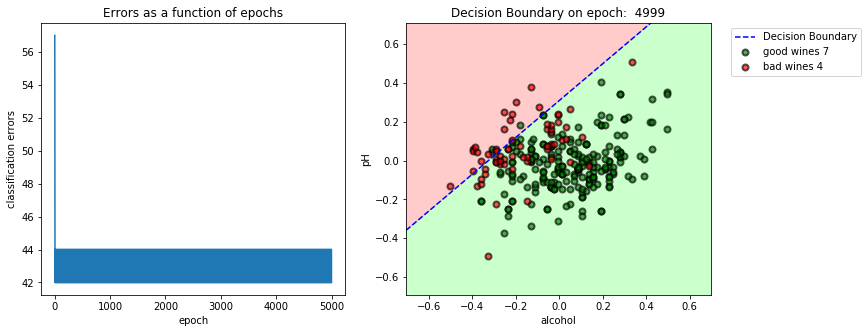

In [62]:
good_threshold = 7
bad_threshold = 4
features = ['alcohol', 'pH']
fig = plot_stats(stats_normalized, X, y, features, good_threshold, bad_threshold, -1)
plt.show(fig)

Perceptron algorithm will loop till a solution is found; however, with thresholds set at 7 and 4, there will be no solution, since the data is not linearly separable. 

Instead, we need to relax the strict constraint set by perceptron and allow the cost function to minimizes the error and allow for some data points to be on the wrong side of the decision boundary.

V.2
b) c)

Implement an ADALINE that:

• Has randomly initialized weights and bias

• Uses a linear activation function and some kind of quantizer 

• Uses the Widrow-Hoff learning rule

You’ll need to implement a function to train your ADALINE. Your training function should:

Take in your red wine data as a parameter

Have a way to specify number of training epochs

If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.

Have a way to specify learning rate.

Have an option to perform either online learning or batch learning

In contrast to the perceptron rule, the delta rule of the adaline (also known as Widrow-Hoff” rule or Adaline rule) updates the weights based on a linear activation function rather than a unit step function; 

here, this linear activation function g(z) is just the identity function of the net input g(wTx) = wTx.

Being a continuous function, one of the biggest advantages of the linear activation function over the unit step function is that it is differentiable. 

This property allows us to define a cost function J(w) that we can minimize in order to update our weights. 

In the case of the linear activation function, we can define the cost function J(w) as the sum of squared errors (SSE), which is similar to the cost function that is minimized in ordinary least squares (OLS) linear regression.



In [0]:
# RESET DATA WITH FEATURE SCALING

good_threshold = 7
bad_threshold = 4
selected_wine_data = wine_data[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
selected_wine_data = selected_wine_data.assign(y = pd.Series(selected_wine_data['quality'] >= good_threshold))

# feature scaling
selected_wine_data['pH'] = feature_scaling(selected_wine_data['pH'])
selected_wine_data['alcohol'] = feature_scaling(selected_wine_data['alcohol'])

X = selected_wine_data.loc[:, ['alcohol', 'pH']]
X = X.reset_index(drop=True)
X.insert(0, 'x0', 1)
y = selected_wine_data.loc[:, ['y']]
y = y.reset_index(drop=True)

In [0]:
# sigmoid activation function is needed because of exploding gradients
# https://www.quora.com/Based-on-your-experience-with-training-Adaline-neural-networks-have-you-noticed-that-weights-have-a-tendency-to-explode/answer/Leo-Mauro?__filter__=&__nsrc__=2&__sncid__=3468645059&__snid3__=5684144952
# THIS VERSION ALLOWS EPOCH = 0 AS SETTING TO DETERMINE OPTIMIZED GOOD WEIGHTS. SEE MSE CALC.

class Adaline(object):
  def __init__(self, lr):
    self.w = None
    self.lr = lr
    self.stats = []

  def _net_input(self, X):
    return ft_dot(self.w, X)

  def _activation_function(self, X):
    net_input = self._net_input(X)
    return 1 / (1 + math.exp(-net_input))

  def predict(self, X):
    return 1 if self._activation_function(X) > 0.5 else 0

  def _eval_epoch(self, X, y):
    num_misclass = 0
    for xi, yi in zip(X, y):
      num_misclass += int(self.predict(xi) != int(yi))
    return num_misclass

  def _train_epoch(self, X, y, epoch, mode, verbose):
    # m length vector of errors of all samples
    # continuous error
    epoch_errors = []

    # zip returns a row of matrix X and an element of vector y
    for xi, yi in zip(X, y):
      yhat = self._activation_function(xi)
      error = yi - yhat
      epoch_errors.append(error)

      # stochastic
      # note, we do not aggregate the error over the entire training sample
      if mode == 'online':
        self.w += self.lr * error * xi

    if mode == 'batch':
      self.w += self.lr * ft_dot(X, epoch_errors)

    num_misclass = self._eval_epoch(X, y)
    if verbose and epoch % 10 == 0:
      print('Epoch {}: {} errors'.format(epoch, num_misclass))
    self.stats.append((epoch, num_misclass, self.w))

    # MSE calculations:
    tot = 0
    for err in epoch_errors:
      tot += err ** 2
    epoch_errors2 = tot / 2

    return epoch_errors2

  def train(self, X, y, epochs, mode='batch', verbose=False, seed=None):
    if seed:
      random.seed(seed)
    if self.w is None:
      self.w = [0.001 * random.uniform(-1, 1) for i in range(X.shape[1])]
    epoch = 0
    while True:
      epoch_errors2 = self._train_epoch(X, y, epoch, mode, verbose)
      #print('{} {}'.format(epoch, epoch_errors2))
      epoch += 1
      if epochs != 0 and epoch == epochs:
        break
      elif epochs == 0 and epoch_errors2 <= 15 and epoch >= 500: # use 15 as threshold for MSE
        break
    return self.stats

  def test_accuracy(self, X, y):
    num_correct = 0
    for xi, yi in zip(X, y):
      num_correct += int(int(yi) == self.predict(xi))
    accuracy = num_correct / len(y)
    print('Test accuracy {} {} {}%'.format(num_correct, len(y), 100*accuracy))
    return accuracy

In [0]:
ad = Adaline(lr=0.001)
epochs = 0
mode = 'batch' # 'batch' or 'online'
stats_ad = ad.train(X.values, y.values, epochs=epochs, mode=mode, verbose=False)

V.2 d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE. What settings tend to give the smallest number of classification errors? Support your reasoning with example plots!

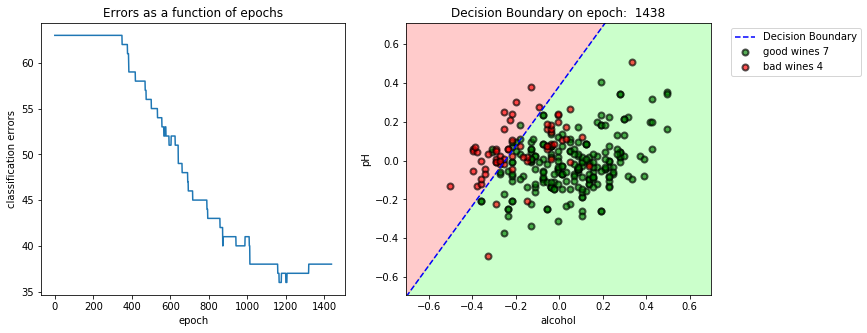

In [66]:
good_threshold = 7
bad_threshold = 4
epoch = epochs - 1
features = ['alcohol', 'pH']
fig = plot_stats(stats_ad, X, y, features, good_threshold, bad_threshold, epoch=epoch)
# epoch = -1 means display the decision boundary based upon the last entry.


In [67]:
# tuning the learning rate
# https://www.geeksforgeeks.org/python-number-uniform-method/
# https://www.programiz.com/python-programming/methods/built-in/round

epochs = 300
mode = 'batch'

for i in range(10):
  lr = round(random.uniform(0.001, 0.05), 5)
  ad = Adaline(lr)
  stats_ad = ad.train(X.values, y.values, epochs=epochs, mode=mode, verbose=False)
  num_misclass = [n[1] for n in stats_ad]
  min_misclass = min(num_misclass)
  last_misclass = stats_ad[-1][1] # last row, column 1
  print('{}, lr: {}, last_misclass {}, min_misclass {}'.format(i, lr, last_misclass, min_misclass))


0, lr: 0.04472, last_misclass 39, min_misclass 37
1, lr: 0.01171, last_misclass 39, min_misclass 36
2, lr: 0.03284, last_misclass 39, min_misclass 36
3, lr: 0.04066, last_misclass 39, min_misclass 36
4, lr: 0.01767, last_misclass 38, min_misclass 36
5, lr: 0.00554, last_misclass 37, min_misclass 36
6, lr: 0.04055, last_misclass 39, min_misclass 36
7, lr: 0.01955, last_misclass 39, min_misclass 36
8, lr: 0.04322, last_misclass 39, min_misclass 36
9, lr: 0.01217, last_misclass 39, min_misclass 36


In [0]:
ad = Adaline(lr=0.04)
epochs = 301
mode = 'batch'
stats_ad = ad.train(X.values, y.values, epochs=epochs, mode=mode, verbose=False)

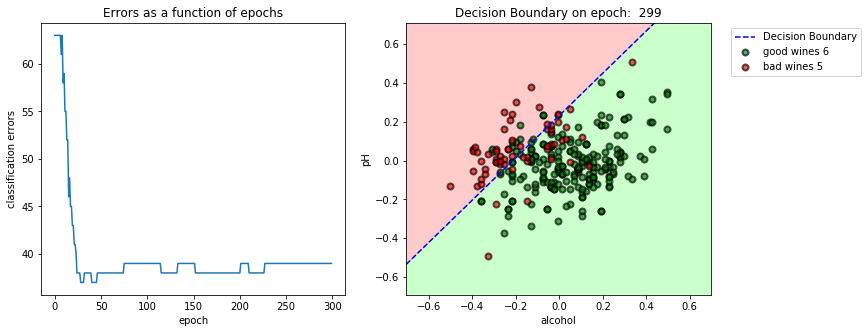

In [72]:
good_threshold = 6
bad_threshold = 5
epoch = epochs - 2
features = ['alcohol', 'pH']
fig = plot_stats(stats_ad, X, y, features, good_threshold, bad_threshold, epoch=epoch)

Extra Notes

In [0]:
# TEST FOR BATCH LEARNING
# TEST FOR STOCHASTIC LEARNING - works
# TEST FOR EPOCHS=0 SETTING, LEARNING TILL BREAK --- DOESN'T WORK!!!
